<a href="https://colab.research.google.com/github/RajkumarGalaxy/ML-Image-Processing/blob/master/Different_losses_in_Tensorflow_on_CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Create the environment

In [77]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from mlxtend.preprocessing import one_hot
from matplotlib import pyplot as plt
import seaborn as sns
# set seed for reproducibility
np.random.seed(1)
tf.random.set_seed(1)

# Load the CIFAR-10 data from Keras Datasets API

In [78]:
data = tf.keras.datasets.cifar10.load_data()
# dataset was grouped already as train and test sets
(train_images,train_labels), (test_images, test_labels) = data

# Normalize images before proceeding
train_images = train_images/ 255.0
test_images = test_images/ 255.0

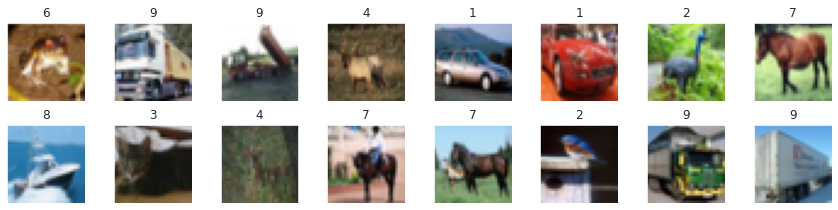

In [79]:
# let's have a look at some images and their labels
plt.figure(figsize=(12,3))
for i in range(16):
  plt.subplot(2,8,i+1)
  plt.imshow(train_images[i])
  plt.title(train_labels[i][0]) # each train label is a ndarray 
  plt.xticks([])
  plt.yticks([])
plt.tight_layout()
plt.show()

In [80]:
# Verify number of unique labels in the dataset
set(np.squeeze(train_labels.reshape(1,-1)))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

# Modeling with different loss functions

In [81]:
# define a function to create a simple CNN model
def Model(loss):
  model = tf.keras.Sequential([
                               # input data are in batches of shape (100,32,32,3)
                               # convolution layer of units 32, kernel 3*3
                               tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)),
                               # max pooling layer of window 2*2
                               tf.keras.layers.MaxPooling2D((2,2)),
                               # l2 regularizer is incorporated to avoid overfitting
                               tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer='l2'),
                               tf.keras.layers.MaxPooling2D((2,2)),
                               tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer='l2'),
                               tf.keras.layers.MaxPooling2D((2,2)),
                               # flatten to develop dense layers after CNN layers
                               tf.keras.layers.Flatten(),
                               tf.keras.layers.Dense(64, activation='relu'),
                               # 10 units in output layer to adapt to 10 classes
                               tf.keras.layers.Dense(10, activation = 'softmax')                               
  ])
  model.compile(# adam with default parameters
                optimizer='adam', 
                # custom loss function with default parameters
                loss = loss,      
                # accuracy is used since dataset is completely balanced among classes
                metrics = ['accuracy'])
  return model

In [82]:
# define a function to pack dataset into tensor batches
def Pack_data(train_X, train_y, test_X, test_y):
  # convert ndarray dataset into tensor dataset, with a batch size of 100
  # shuffle is not mandatory for train data since we are about to compare loss functions
  train_data = tf.data.Dataset.from_tensor_slices((train_X, train_y)).batch(100)
  test_data = tf.data.Dataset.from_tensor_slices((test_X, test_y)).batch(100)
  return train_data, test_data

# Training with Sparse Categorical Cross Entropy Loss

In [83]:
# create train and test datasets to feed to model 
train_data, test_data = Pack_data(train_images, train_labels, test_images, test_labels)

In [84]:
%%time
# with identical parameters, we can compare time taken by models with diff loss functions
# magic command %%time outputs time taken by the code cell
model_scce = Model(loss='sparse_categorical_crossentropy')
hist_scce = model_scce.fit(train_data, validation_data=test_data, epochs=10, verbose=0)

CPU times: user 18min 28s, sys: 17.2 s, total: 18min 46s
Wall time: 9min 56s


# Training with Categorical Cross Entropy Loss

In [86]:
train_labels.shape

(50000, 1)

In [87]:
train_labels_one_hot = one_hot(np.squeeze(train_labels))
test_labels_one_hot = one_hot(np.squeeze(test_labels))
for i in range(10):
  print('before onehot ', train_labels[i], ' ... after onehot ', train_labels_one_hot[i])

before onehot  [6]  ... after onehot  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
before onehot  [9]  ... after onehot  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
before onehot  [9]  ... after onehot  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
before onehot  [4]  ... after onehot  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
before onehot  [1]  ... after onehot  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
before onehot  [1]  ... after onehot  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
before onehot  [2]  ... after onehot  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
before onehot  [7]  ... after onehot  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
before onehot  [8]  ... after onehot  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
before onehot  [3]  ... after onehot  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [88]:
train_data_OH, test_data_OH = Pack_data(train_images, train_labels_one_hot, test_images, test_labels_one_hot)

In [89]:
%%time
model_cce = Model(loss='categorical_crossentropy')
hist_cce = model_cce.fit(train_data_OH, validation_data=test_data_OH, epochs=10, verbose=0)

CPU times: user 18min 25s, sys: 18.6 s, total: 18min 44s
Wall time: 10min 5s


# Training with Kullback-Leibler Divergence Loss

In [90]:
%%time
model_kld = Model(loss='kullback_leibler_divergence')
hist_kld = model_kld.fit(train_data_OH, validation_data=test_data_OH, epochs=10, verbose=0)

CPU times: user 18min 26s, sys: 19 s, total: 18min 45s
Wall time: 10min 3s


# Compare Performance of Different Models with Visualizations

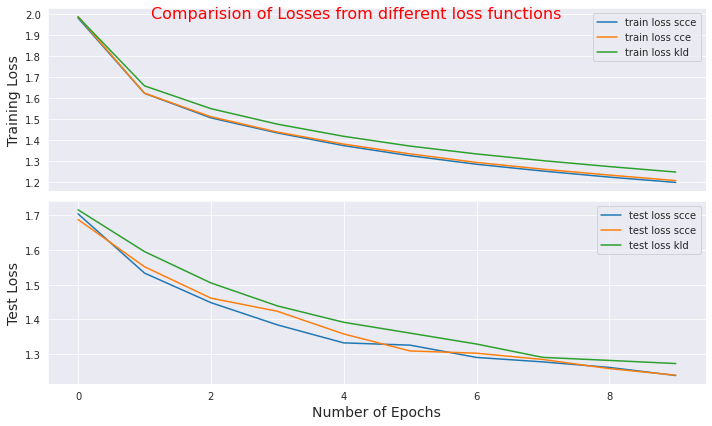

In [100]:
# grids increase comparability
sns.set_style('darkgrid') 
plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
# sparse categorical cross entropy 
plt.plot(hist_scce.history['loss'], label='train loss scce')
# categorical cross entropy
plt.plot(hist_cce.history['loss'], label='train loss cce')
# kullback-leibler divergence
plt.plot(hist_kld.history['loss'], label='train loss kld')
plt.ylabel('Training Loss', size=14)
plt.xticks([])
plt.legend()
plt.subplot(2,1,2)
# sparse categorical cross entropy 
plt.plot(hist_scce.history['val_loss'], label='test loss scce')
# categorical cross entropy
plt.plot(hist_cce.history['val_loss'], label='test loss scce')
# kullback-leibler divergence
plt.plot(hist_kld.history['val_loss'], label='test loss kld')
plt.ylabel('Test Loss', size=14)
plt.xlabel('Number of Epochs', size=14)
plt.suptitle('Comparision of Losses from different loss functions', color='r', size=16)
plt.legend()
plt.tight_layout()
plt.show()

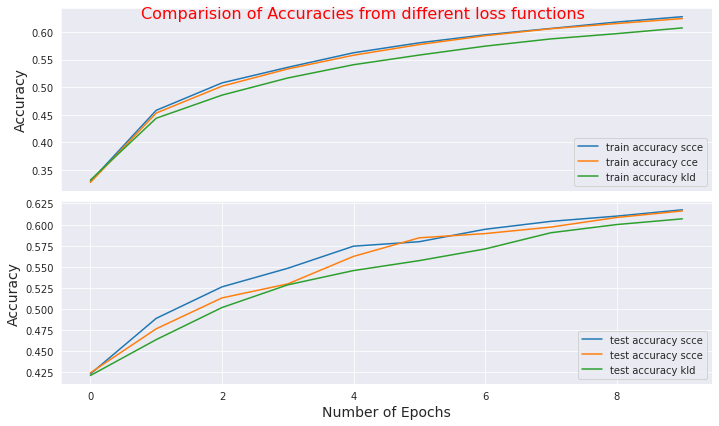

In [107]:
plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
# sparse categorical cross entropy 
plt.plot(hist_scce.history['accuracy'], label='train accuracy scce')
# categorical cross entropy
plt.plot(hist_cce.history['accuracy'], label='train accuracy cce')
# kullback-leibler divergence
plt.plot(hist_kld.history['accuracy'], label='train accuracy kld')
plt.ylabel('Accuracy', size=14)
plt.xticks([])
plt.legend(loc='lower right')
plt.subplot(2,1,2)
# sparse categorical cross entropy 
plt.plot(hist_scce.history['val_accuracy'], label='test accuracy scce')
# categorical cross entropy
plt.plot(hist_cce.history['val_accuracy'], label='test accuracy scce')
# kullback-leibler divergence
plt.plot(hist_kld.history['val_accuracy'], label='test accuracy kld')
plt.ylabel('Accuracy', size=14)
plt.xlabel('Number of Epochs', size=14)
plt.suptitle('Comparision of Accuracies from different loss functions', color='r', size=16)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

### It can be visualized that both Sparse categorical cross entropy loss and Categorical cross entropy loss perform almost identical in terms of training and validation losses and accuracies. On the other hand, Kullback-Leibler divergence loss relatively underperform for this CIFAR-10 dataset. It should be noted that hyper-parameter tuning is not performed for any of loss functions and used with default parameters. Tuning may improve the performance of loss functions. It can also be noticed that model with sparse categorical cross entropy took relatively lesser time to train, since integer labels are used which are memory efficient. In overall, sparse categorical cross entropy loss performed well with good time efficiency for CIFAR-10 dataset.


### Thank you for your time!